Negative samples generation recipe:

For a cocrystal pair (molA,molB), a constructed negative sample will be generated according to the following steps:

(i)	Randomly choose a molecule between molA and molB. Without the loss of generality, suppose that molA is chosen.

(ii)	Randomly choose another cocrystal pair (molC,molD) from the whole cocrystal data set.

(iii)	Randomly choose a molecule between molC and molD. Without the loss of generality, suppose that molC is chosen.

(iv)	Calculate the ECFP4-based Tanimoto similarity coefficient (Tc) (24) between molC and each coformer of molA. If there exists at least one coformer of molA, for example, named as molAi, that satisfies the condition
	(1)Tc(molC,molAi)>=0.6
then discard molC and return to step ii.

(v)	(molA,molC) is consequently generated as a negative sample for (molA,molB).

In [15]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.DataStructs import FingerprintSimilarity
import random

random.seed(42)

# Read the maccs_fingerprints.csv file
df = pd.read_csv('maccs_fingerprints.csv')

# Define a function to calculate the Tanimoto similarity coefficient
def calculate_tanimoto_similarity(fp1, fp2):
    return FingerprintSimilarity(fp1, fp2)

# Define a function to generate negative samples
def generate_negative_samples(df, threshold=0.4, num_samples=7655):
    negative_samples = []
    
    while len(negative_samples) < num_samples:
        # Randomly select a co-crystal pair
        random_row = df.sample(n=1)
        molA_smiles = random_row.iloc[0]['coformer1']
        
        # Find all rows containing molA
        molA_rows = df[(df['coformer1'] == molA_smiles) | (df['coformer2'] == molA_smiles)]
        
        # Extract the other monomer's SMILES from these rows
        other_smiles_list = [row['coformer2'] if row['coformer1'] == molA_smiles else row['coformer1'] for index, row in molA_rows.iterrows()]
        
        # Randomly select another co-crystal pair
        while True:
            random_row = df.sample(n=1)
            molC_smiles = random_row.iloc[0]['coformer1'] if random_row.iloc[0]['coformer1'] != molA_smiles else random_row.iloc[0]['coformer2']
            
            # Generate MACCS fingerprints
            molA_fp = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(molA_smiles))
            molC_fp = MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(molC_smiles))
            
            # Calculate the Tanimoto similarity coefficient between molC and all other monomers of molA
            is_similar = any(calculate_tanimoto_similarity(molC_fp, MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(other_smiles))) >= threshold for other_smiles in other_smiles_list)
            
            # If molC is similar to any other monomer of molA (similarity >= threshold), select another molC
            if is_similar:
                continue
            
            # If molC is not similar to any other monomer of molA (all similarities < threshold), keep the SMILES of molA and molC
            negative_samples.append((molA_smiles, molC_smiles))
            break

    return negative_samples

# Generate negative samples
negative_samples = generate_negative_samples(df)

# Convert negative samples to a DataFrame
negative_samples_df = pd.DataFrame(negative_samples, columns=['coformer1', 'coformer2'])

# Save to a CSV file
negative_samples_df.to_csv('negative_samples.csv', index=False)

[17:46:14] Conflicting single bond directions around double bond at index 1.
[17:46:14]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [16]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys

# Read the negative_samples.csv file
df = pd.read_csv('negative_samples.csv')

# Define a function to generate MACCS fingerprints
def generate_maccs_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return MACCSkeys.GenMACCSKeys(mol)

# Create empty columns for MACCS fingerprints
for i in range(167):
    df[f'maccs_bit_{i+1}'] = 0

# Iterate over the DataFrame to generate MACCS fingerprints for each pair of SMILES strings
for index, row in df.iterrows():
    molA_fp = generate_maccs_fp(row['coformer1'])
    molC_fp = generate_maccs_fp(row['coformer2'])
    
    # Combine the two MACCS fingerprints by adding corresponding bits
    combined_fp = ''.join(str(int(a) + int(b)) for a, b in zip(molA_fp.ToBitString(), molC_fp.ToBitString()))
    
    # If combined_fp is less than 167 bits, pad with zeros
    combined_fp = combined_fp.ljust(167, '0')
    
    # Assign the combined_fp to the new columns
    for i in range(167):
        df.at[index, f'maccs_bit_{i+1}'] = combined_fp[i]

# Add a new column 'form' and set all values to 0
df['form'] = 0

# Save the updated DataFrame to negative_samples_maccs.csv
df.to_csv('negative_samples_maccs.csv', index=False)

C:\Users\15710\.conda\envs\cocrystal_py37\lib\site-packages\ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


after some manual adjustment of dataset 

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from joblib import dump

# Read the positive and negative sample datasets
df_positive = pd.read_csv('maccs_fingerprints.csv')
df_negative = pd.read_csv('negative_samples_maccs.csv')

# Concatenate the datasets
df_combined = pd.concat([df_positive, df_negative], ignore_index=True)

# Shuffle the dataset with a random seed of 42
np.random.seed(42)
df_shuffled = df_combined.sample(frac=1).reset_index(drop=True)

# Columns 4 to 170 are features, and the last column is the target
X = df_shuffled.iloc[:, 3:170].values
y = df_shuffled['form'].values

# Split the dataset into training and testing sets with a ratio of 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

# Save the model
dump(rf_model, 'rf_model_all_simulate_300.joblib')

Accuracy: 0.910871694417238
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1552
           1       0.92      0.90      0.91      1511

    accuracy                           0.91      3063
   macro avg       0.91      0.91      0.91      3063
weighted avg       0.91      0.91      0.91      3063



['rf_model_all_simulate_300.joblib']

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from joblib import dump

# Read the positive and negative sample datasets
df_positive = pd.read_csv('maccs_fingerprints.csv')
df_negative = pd.read_csv('negative_samples_maccs.csv')

# Concatenate the datasets
df_combined = pd.concat([df_positive, df_negative], ignore_index=True)

# Shuffle the dataset with a random seed of 42
np.random.seed(42)
df_shuffled = df_combined.sample(frac=1).reset_index(drop=True)

# Columns 4 to 170 are features, and the last column is the target
X = df_shuffled.iloc[:, 3:170].values
y = df_shuffled['form'].values

# Split the dataset into training and testing sets with a ratio of 7:3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

# Save the model
dump(rf_model, 'rf_model_all_simulate_300.joblib')

Accuracy: 0.9103178058336961
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2306
           1       0.93      0.89      0.91      2288

    accuracy                           0.91      4594
   macro avg       0.91      0.91      0.91      4594
weighted avg       0.91      0.91      0.91      4594



['rf_model_all_simulate_300.joblib']

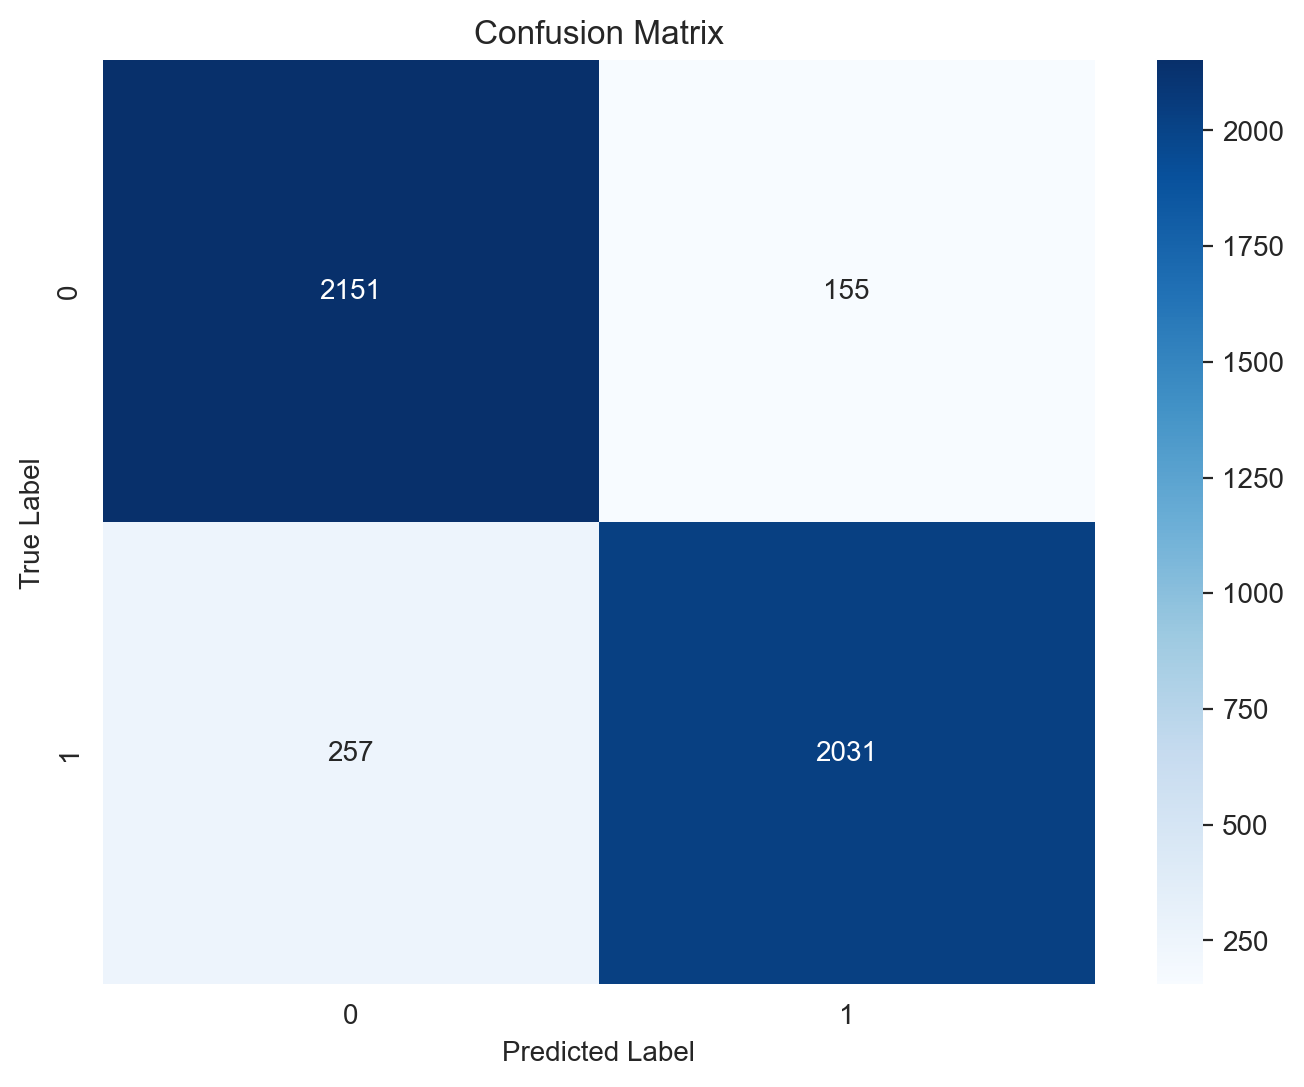

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set the size of the figure
plt.figure(figsize=(8, 6), dpi=200)

# Use seaborn's heatmap function to plot the heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set the title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the plot
plt.show()

In [21]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys

# Read the ca_60_smiles.csv file
df = pd.read_csv('ca_60_smiles.csv')

# Define a function to generate MACCS fingerprints
def generate_maccs_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return MACCSkeys.GenMACCSKeys(mol)

# Create empty columns for MACCS fingerprints
for i in range(167):
    df[f'maccs_bit_{i+1}'] = 0

# Iterate over the DataFrame to generate MACCS fingerprints for each pair of SMILES strings
for index, row in df.iterrows():
    molA_fp = generate_maccs_fp(row['coformer1'])
    molC_fp = generate_maccs_fp(row['coformer2'])
    
    # Combine the two MACCS fingerprints by adding corresponding bits
    combined_fp = ''.join(str(int(a) + int(b)) for a, b in zip(molA_fp.ToBitString(), molC_fp.ToBitString()))
    
    # If combined_fp is less than 167 bits, pad with zeros
    combined_fp = combined_fp.ljust(167, '0')
    
    # Assign the combined_fp to the new columns
    for i in range(167):
        df.at[index, f'maccs_bit_{i+1}'] = combined_fp[i]

# Save the updated DataFrame to ca_60_smiles_maccs.csv
df.to_csv('ca_60_smiles_maccs.csv', index=False)

C:\Users\15710\.conda\envs\cocrystal_py37\lib\site-packages\ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


In [25]:
from joblib import load
import pandas as pd
import numpy as np

# Load the trained Random Forest model
model = load('rf_model_all_simulate_300.joblib')

# Read the test dataset
test_df = pd.read_csv('ca_60_smiles_maccs.csv')

# Extract columns 4 to 170 as features
X_test = test_df.iloc[:, 3:170].values

# Use the model to make predictions, getting the probability of being class 1
predicted_probabilities = model.predict_proba(X_test)

# Round the predicted probabilities for class 1 to two decimal places
rounded_predicted_probabilities = np.round(predicted_probabilities[:, 1], 2)

# Add the rounded predicted probabilities to the DataFrame
test_df['predicted_form_prob'] = rounded_predicted_probabilities  # Assuming the positive class label is 1

# Save the predictions to a new CSV file
test_df.to_csv('ca_60_maccs_predictions.csv', index=False)

# Print the first few rows of the predictions
print(test_df.head())

   id                     coformer1  \
0   1  O=C(C(Cl)=C1O)C(O)=C(Cl)C1=O   
1   2  O=C(C(Cl)=C1O)C(O)=C(Cl)C1=O   
2   3  O=C(C(Cl)=C1O)C(O)=C(Cl)C1=O   
3   4  O=C(C(Cl)=C1O)C(O)=C(Cl)C1=O   
4   5  O=C(C(Cl)=C1O)C(O)=C(Cl)C1=O   

                                        coformer2  maccs_bit_1  maccs_bit_2  \
0                            c1ccc2nc3ccccc3nc2c1            0            0   
1                           CC1=NC2=CC=CC=C2N=C1C            0            0   
2                            c1cnc2cc3nccnc3cc2n1            0            0   
3                    c1nc2cc3nc4ccccc4nc3cc2[nH]1            0            0   
4  c1ccc2nc3c(nc2c1)c1nc2ccccc2nc1c1nc2ccccc2nc31            0            0   

   maccs_bit_3  maccs_bit_4  maccs_bit_5  maccs_bit_6  maccs_bit_7  ...  \
0            0            0            0            0            0  ...   
1            0            0            0            0            0  ...   
2            0            0            0            0            